# Disorder Analysis 
this notebook aims to take an amminoacid sequence and perform an analysis using ML algorithms to determine wether a single residue is disordered or not
## 1: importing libraries

In [23]:
import numpy as np
import pandas as pd
import requests
import json
import Bio
import sklearn
from Bio.SeqUtils.ProtParam import ProteinAnalysis # information on ammino acids
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## 2: importing the dataset
We are importing the full dataset from UniProt

In [25]:
# Download DisProt dataset
url = "https://disprot.org/api/search"
response = requests.get(url)
# Then parse JSON to get sequences and labels

data = response.json()
data.keys()

dict_keys(['data', 'size'])

In [3]:
print('Number of available files:',data['size'])
nfiles = data['size']
data = data['data']

# each entry is a JSON which corresponds to a protein

Number of available files: 3201


In [4]:
# we select MMACHC sequence
sel_sequence = 'MEPKVAELKQKIEDTLCPFGFEVYPFQVAWYNELLPPAFHLPLPGPTLAFLVLSTPAMFDRALKPFLQSCHLRMLTDPVDQCVAYHLGRVRESLPELQIEIIADYEVHPNRRPKILAQTAAHVAGAAYYYQRQDVEADPWGNQRISGVCIHPRFGGWFAIRGVVLLPGIEVPDLPPRKPHDCVPTRADRIALLEGFNFHWRDWTYRDAVTPQERYSEEQKAYFSTPPAQRLALLGLAQPSEKPSSPSPDLPFTTPAPKKPGNPSRARSWLSPRVSPPASPGP' 
for i in (range(nfiles)):
    if(data[i]['sequence'] == sel_sequence):
        print('index of selected sequence:',i)
        sel_index = i


index of selected sequence: 2766


In [5]:
print('Desired protein is', data[sel_index]['name'], 'of length', data[sel_index]['length'])
test_protein = data[sel_index]['name']

Desired protein is Cyanocobalamin reductase / alkylcobalamin dealkylase of length 282


Since we correctly identified the desired protein from the dataset, we remove it, as well as a sufficient portion of remaining proteins (~20%) to use as validation set and test the performance of the model. 

In the following cells we will extract relevant information of the proteins for our purposes, removing the nested JSON structure in favour of a pandas dataframe. Then we will proceed with dividing the dataset in the above descripted parts.

### 2.1: Extracting relevant protein features

In [6]:
# defining Kyle-Dottle hydrofobicity
kd_hydrophobicity = {
    'A': 1.8,  'C': 2.5,  'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5,  'K': -3.9, 'L': 3.8,
    'M': 1.9,  'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2,  'W': -0.9, 'Y': -1.3,
}

# get hydro given sequence
def get_hydro(seq):
    return np.array([kd_hydrophobicity.get(aa, 0) for aa in seq])

# sliding window to compute hydrofobicity over small sequences
def sliding_window_avg(arr, window_size):
    half = window_size // 2
    n = len(arr)
    avg = np.zeros(n)
    for i in range(n):
        start = max(0, i - half)
        end = min(n, i + half + 1)
        avg[i] = arr[start:end].mean()
    return avg

In [7]:
rows = []

# for loop over the proteins
for protein in data:
    seq = protein['sequence'] # extract the sequence of amminoacids
    name = protein['name'] # save the name for cross check
    prot_id = protein['disprot_id']
    n = len(seq)

    labels = [0] * n # initialize labels to zeros (all ordered)

    # for loop over all possible regions of a protein
    for region in protein['regions']:
        if region['term_name'] in ('disorder','disorder to order'):
            start = region['start'] - 1
            end = region['end'] # save start and end points of each disordered region
            for i in range(start,end):
                labels[i] = 1 # convert correct zones to class 1

    # hydrofobicity computation
    hydro_vals = get_hydro(seq)
    hydro_7 = sliding_window_avg(hydro_vals, 7)
    hydro_15 = sliding_window_avg(hydro_vals, 15)
    
    # append row
    for i, aa in enumerate(seq):
        rows.append({
            'protein': name,
            'prot_id': prot_id,
            'residue': aa,
            'label': labels[i],
            'hydro_7': hydro_7[i],
            'hydro_15': hydro_15[i]
        })

df = pd.DataFrame(rows)
    

In [8]:
df

,protein,prot_id,residue,label,hydro_7,hydro_15
0,DNA-binding protein,DP00003,M,0,-0.400000,-1.950000
1,DNA-binding protein,DP00003,A,0,-1.020000,-2.233333
2,DNA-binding protein,DP00003,S,0,-1.433333,-2.360000
3,DNA-binding protein,DP00003,R,0,-1.728571,-2.209091
4,DNA-binding protein,DP00003,E,0,-2.500000,-2.083333
...,...,...,...,...,...,...
1873447,Functional amyloid subunit FapB,DP04435,G,1,1.028571,-0.083333
1873448,Functional amyloid subunit FapB,DP04435,V,1,0.971429,0.227273
1873449,Functional amyloid subunit FapB,DP04435,T,1,1.250000,0.700000
1873450,Functional amyloid subunit FapB,DP04435,I,1,0.740000,0.566667


### Rescaling the features
We are going to standardscale the numeric features

In [9]:
columns = df.columns
scaler = StandardScaler()
n_features_to_scale = 2
scaler.fit(df[columns[-n_features_to_scale:]])
scaled_features = scaler.transform(df[columns[-n_features_to_scale:]])
df[columns[-n_features_to_scale:]] = scaled_features
df

,protein,prot_id,residue,label,hydro_7,hydro_15
0,DNA-binding protein,DP00003,M,0,0.048643,-1.748411
1,DNA-binding protein,DP00003,A,0,-0.480273,-2.080141
2,DNA-binding protein,DP00003,S,0,-0.832884,-2.228443
3,DNA-binding protein,DP00003,R,0,-1.084749,-2.051757
4,DNA-binding protein,DP00003,E,0,-1.742847,-1.904519
...,...,...,...,...,...,...
1873447,Functional amyloid subunit FapB,DP04435,G,1,1.267343,0.437102
1873448,Functional amyloid subunit FapB,DP04435,V,1,1.218595,0.800763
1873449,Functional amyloid subunit FapB,DP04435,T,1,1.456242,1.354237
1873450,Functional amyloid subunit FapB,DP04435,I,1,1.021166,1.198129


### Splitting the sets

In [10]:
test_set = df[df['protein'] == test_protein].reset_index(drop = True) # take out the test protein
rest_set = df[df['protein'] != test_protein].reset_index(drop = True) # take the rest

test_set

,protein,prot_id,residue,label,hydro_7,hydro_15
0,Cyanocobalamin reductase / alkylcobalamin deal...,DP03867,M,0,-1.124356,0.417588
1,Cyanocobalamin reductase / alkylcobalamin deal...,DP03867,E,0,-0.104913,-0.076754
2,Cyanocobalamin reductase / alkylcobalamin deal...,DP03867,P,0,0.233479,-0.425395
3,Cyanocobalamin reductase / alkylcobalamin deal...,DP03867,K,0,-0.170723,-0.753222
4,Cyanocobalamin reductase / alkylcobalamin deal...,DP03867,V,0,0.060830,-0.206844
...,...,...,...,...,...,...
277,Cyanocobalamin reductase / alkylcobalamin deal...,DP03867,A,1,-0.219471,-0.372709
278,Cyanocobalamin reductase / alkylcobalamin deal...,DP03867,S,1,-0.316967,-0.370048
279,Cyanocobalamin reductase / alkylcobalamin deal...,DP03867,P,1,-0.207284,-0.273190
280,Cyanocobalamin reductase / alkylcobalamin deal...,DP03867,G,1,-0.053728,0.222453


In [11]:
rest_set

,protein,prot_id,residue,label,hydro_7,hydro_15
0,DNA-binding protein,DP00003,M,0,0.048643,-1.748411
1,DNA-binding protein,DP00003,A,0,-0.480273,-2.080141
2,DNA-binding protein,DP00003,S,0,-0.832884,-2.228443
3,DNA-binding protein,DP00003,R,0,-1.084749,-2.051757
4,DNA-binding protein,DP00003,E,0,-1.742847,-1.904519
...,...,...,...,...,...,...
1873165,Functional amyloid subunit FapB,DP04435,G,1,1.267343,0.437102
1873166,Functional amyloid subunit FapB,DP04435,V,1,1.218595,0.800763
1873167,Functional amyloid subunit FapB,DP04435,T,1,1.456242,1.354237
1873168,Functional amyloid subunit FapB,DP04435,I,1,1.021166,1.198129


### Subsetting the dataset
Here we take only a fraction of proteins from the dataset to avoid kernel crashes

In [12]:
unique_prot = np.unique(rest_set['prot_id'])
n_prots = 100
sel_prot = unique_prot[:n_prots]

rest_set = rest_set[rest_set['prot_id'].isin(sel_prot)]
rest_set

,protein,prot_id,residue,label,hydro_7,hydro_15
0,DNA-binding protein,DP00003,M,0,0.048643,-1.748411
1,DNA-binding protein,DP00003,A,0,-0.480273,-2.080141
2,DNA-binding protein,DP00003,S,0,-0.832884,-2.228443
3,DNA-binding protein,DP00003,R,0,-1.084749,-2.051757
4,DNA-binding protein,DP00003,E,0,-1.742847,-1.904519
...,...,...,...,...,...,...
81113,Synaptic functional regulator FMR1,DP00134,V,1,0.779863,0.378561
81114,Synaptic functional regulator FMR1,DP00134,N,1,1.011416,-0.082667
81115,Synaptic functional regulator FMR1,DP00134,G,1,1.342497,0.265383
81116,Synaptic functional regulator FMR1,DP00134,V,1,0.884671,0.287498


In [13]:
print(f"Percentage of class 0 points in training: {round((len(rest_set[rest_set['label']==0]) / len(rest_set['label']) * 100),3) }%")
print(f"Percentage of class 1 points in training: {round((len(rest_set[rest_set['label']==1]) / len(rest_set['label']) * 100),3) }%")


Percentage of class 0 points in training: 81.462%
Percentage of class 1 points in training: 18.538%


## 3: Random forest model
Many models can be used to compute this task. One of them are for sure **random forests**.
We train a random forest using a sliding window approach to the features X and implementing a 1:1 correspondance with a single label Y centered (if possible) in the middle of the interval of the window. The size of the window is a tunable parameter, as well as the structure of the forest
### 3.1: Setting up the data

In [14]:
# one-hot encode residues (test_set)
residues = test_set[['residue']]
onehot_encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')
res_onehot = onehot_encoder.fit_transform(residues)

# combine one hot and numeric features
num_feat = test_set[columns[-n_features_to_scale:]].values
X_test = np.hstack([res_onehot, num_feat]) # stack
Y_test = test_set['label'].values # take labels
prot_test = test_set['prot_id'].values # isolate single proteins

# one-hot encode residues (rest_set)
residues = rest_set[['residue']]
onehot_encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')
res_onehot = onehot_encoder.fit_transform(residues)

# combine one hot and numeric features
num_feat = rest_set[columns[-n_features_to_scale:]].values
X_rest = np.hstack([res_onehot, num_feat]) # stack
Y_rest = rest_set['label'].values # take labels
prot_rest = rest_set['prot_id'].values # isolate single proteins





In [15]:
def build_sliding_window_dataset(features, labels, proteins, window_size):
    assert window_size % 2 == 1, "Window size must be odd"
    k = window_size // 2
    X_out, y_out = [], []

    # none if computing the selected protein's windows
    if proteins is None or len(proteins) == 0:
        # Treat all features as one long sequence
        pad_width = ((k, k), (0, 0))
        padded = np.pad(features, pad_width, mode='constant')

        for idx in range(k, len(features) + k):
            window = padded[idx - k:idx + k + 1].flatten()
            X_out.append(window)
            y_out.append(labels[idx - k])

    else:
        # Process by protein chunks
        i = 0
        while i < len(features):
            current_prot = proteins[i]
            j = i
            while j < len(proteins) and proteins[j] == current_prot:
                j += 1

            f_block = features[i:j]
            l_block = labels[i:j]

            pad_width = ((k, k), (0, 0))
            padded = np.pad(f_block, pad_width, mode='constant')

            for idx in range(k, len(f_block) + k):
                window = padded[idx - k:idx + k + 1].flatten()
                X_out.append(window)
                y_out.append(l_block[idx - k])

            i = j

    return np.array(X_out), np.array(y_out)


In [16]:
def grid_search_k_rf(features, labels, proteins, 
                     window_sizes=[5, 7, 9], 
                     n_estimators_list=[50, 100], 
                     max_depth_list=[5, 10, None]):
    best_score = -1
    best_model = None
    best_params = None

    for k in window_sizes:
        X, y = build_sliding_window_dataset(features, labels, proteins, window_size=k)

        # resampling with SMOTE
        sm = SMOTE(random_state=42, k_neighbors = 2)
        X, y = sm.fit_resample(X, y)
        ###
        
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        for n_est in n_estimators_list:
            for depth in max_depth_list:
                scores = []
                for train_idx, val_idx in skf.split(X, y):
                    clf = RandomForestClassifier(n_estimators=n_est, 
                                                 max_depth=depth, 
                                                 random_state=42, 
                                                 n_jobs=-1,
                                                 class_weight = 'balanced' # this balances classes with reasonable weights
                                                )
                    clf.fit(X[train_idx], y[train_idx])
                    y_pred = clf.predict(X[val_idx])
                    scores.append(f1_score(y[val_idx], y_pred, average = 'binary'))

                avg_score = np.mean(scores)
                print(f"k={k}, n={n_est}, depth={depth}, f1 score={avg_score:.4f}")

                if avg_score > best_score:
                    best_score = avg_score
                    best_model = clf
                    best_params = {'k': k, 'n_estimators': n_est, 'max_depth': depth}

    return best_model, best_params, best_score

In [17]:
best_model, best_params, best_score = grid_search_k_rf(
    X_rest, Y_rest, prot_rest,
    window_sizes=[5, 9, 15, 19],
    n_estimators_list=[50, 100, 150],
    max_depth_list=[25, 50]
)

print("Best params:", best_params)
print("Best F1 score:", best_score)

k=5, n=50, depth=25, f1 score=0.8748
k=5, n=50, depth=50, f1 score=0.9045
k=5, n=100, depth=25, f1 score=0.8775
k=5, n=100, depth=50, f1 score=0.9066
k=5, n=150, depth=25, f1 score=0.8791
k=5, n=150, depth=50, f1 score=0.9087
k=9, n=50, depth=25, f1 score=0.8942
k=9, n=50, depth=50, f1 score=0.9084
k=9, n=100, depth=25, f1 score=0.8969
k=9, n=100, depth=50, f1 score=0.9100
k=9, n=150, depth=25, f1 score=0.8981
k=9, n=150, depth=50, f1 score=0.9110
k=15, n=50, depth=25, f1 score=0.8980
k=15, n=50, depth=50, f1 score=0.9071
k=15, n=100, depth=25, f1 score=0.9012
k=15, n=100, depth=50, f1 score=0.9088
k=15, n=150, depth=25, f1 score=0.9020
k=15, n=150, depth=50, f1 score=0.9098
k=19, n=50, depth=25, f1 score=0.8987
k=19, n=50, depth=50, f1 score=0.9064
k=19, n=100, depth=25, f1 score=0.9010
k=19, n=100, depth=50, f1 score=0.9079
k=19, n=150, depth=25, f1 score=0.9021
k=19, n=150, depth=50, f1 score=0.9088
Best params: {'k': 9, 'n_estimators': 150, 'max_depth': 50}
Best F1 score: 0.9110007

In [18]:
n_est = best_params['n_estimators']
depth = best_params['max_depth']
k = best_params['k']

protein = None

X, y = build_sliding_window_dataset(X_test, Y_test, protein, window_size=k)


best_RF = RandomForestClassifier(n_estimators=n_est, 
                                                 max_depth=depth, 
                                                 random_state=42, 
                                                 n_jobs=-1,
                                                 class_weight = 'balanced' # this balances classes with reasonable weights
                                                )

best_RF.fit(X, y)
y_pred = best_RF.predict(X)
print(f"f1 score of best model on test set: {f1_score(y, y_pred, average = 'binary')}")



f1 score of best model on test set: 1.0


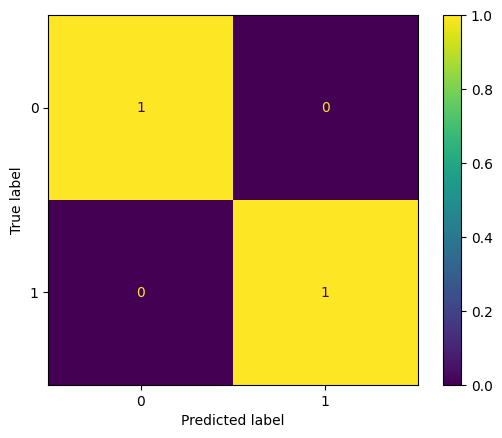

In [19]:
cm = confusion_matrix(y, y_pred, normalize = 'true')
disp = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels = best_RF.classes_)
disp.plot()
plt.show()


In [21]:
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


np.int64(52)

In [22]:
52/len(y_pred)

0.18439716312056736